In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('bmh')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
sales = pd.read_csv('/Users/sg/projects/EDS-I-Group-Project/data/family_stores_unit_sales.csv')

In [4]:
import mlflow

remote_server_uri = "databricks" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("/my-experiment")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/173139626917049', experiment_id='173139626917049', lifecycle_stage='active', name='/my-experiment', tags={'mlflow.experiment.sourceName': '/my-experiment',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'shivanshug14+unsub@gmail.com',
 'mlflow.ownerId': '3176862807905950'}>

In [5]:
sales.head()

,family,store_nbr,year_week,unit_sales,type
0,BEVERAGES,10,201301,4349.000,C
1,BEVERAGES,10,201302,3126.000,C
2,BEVERAGES,10,201303,3001.000,C
3,BEVERAGES,10,201304,2895.000,C
4,BEVERAGES,10,201305,3037.000,C


In [6]:
# keep only type C stores
sales_c = sales[sales['type'] == 'C'][['family', 'year_week', 'unit_sales']].reset_index(drop = True)

In [7]:
year_list = []
for i in range(len(sales_c['year_week'])):
    year_list.append(str(list(sales_c['year_week'])[i])[:4])

week_list = []
for i in range(len(sales_c['year_week'])):
    week_list.append(str(list(sales_c['year_week'])[i])[4:])

sales_c['year'] = year_list
sales_c['year'] = sales_c['year'].astype(int)
sales_c['week'] = week_list
sales_c['week'] = sales_c['week'].astype(int)

In [8]:
dates = sales_c['year']*100 + sales_c['week']
sales_c['date'] = pd.to_datetime(dates.astype(str) + '0', format = '%Y%W%w')

In [9]:
sales_c.head()

,family,year_week,unit_sales,year,week,date
0,BEVERAGES,201301,4349.000,2013,1,2013-01-13
1,BEVERAGES,201302,3126.000,2013,2,2013-01-20
2,BEVERAGES,201303,3001.000,2013,3,2013-01-27
3,BEVERAGES,201304,2895.000,2013,4,2013-02-03
4,BEVERAGES,201305,3037.000,2013,5,2013-02-10


In [10]:
sales_c = sales_c[[ 'date','family' ,'unit_sales']] # work with the datetime column from now on

# filter to have only until the last complete month in the data, which is July
sales_c = sales_c[(sales_c.date <= '2017-07-01') ]
sales_c.date.max()

Timestamp('2017-06-25 00:00:00')

In [11]:
sales_c.head()

,date,family,unit_sales
0,2013-01-13,BEVERAGES,4349.000
1,2013-01-20,BEVERAGES,3126.000
2,2013-01-27,BEVERAGES,3001.000
3,2013-02-03,BEVERAGES,2895.000
4,2013-02-10,BEVERAGES,3037.000


In [12]:
# reshape the table to make analysis easier: one column per family
sales_c_ts = pd.pivot_table(sales_c, 
               values='unit_sales',
               index='date', 
               columns = 'family'
          ).fillna(0)

In [13]:
df_ts = sales_c_ts.asfreq('W') # we define the sampling frequency as weekly, this will help with the visuals 

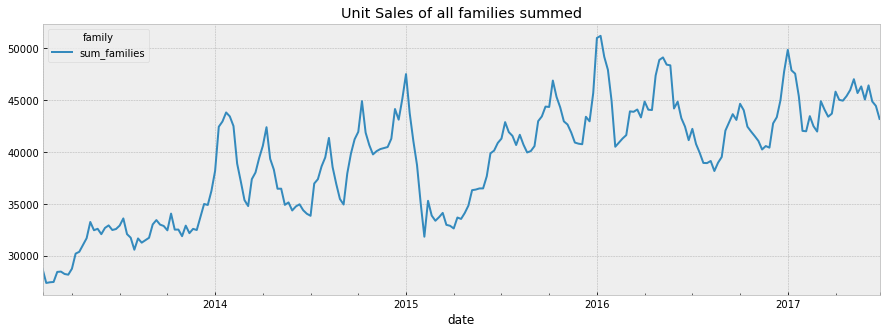

In [14]:
fig, ax = plt.subplots(figsize = (13,5))


sales_c_ts['sum_families']= sales_c_ts.sum(axis=1) # a TOTALS column to sum all families
df_ts_smoothed = sales_c_ts.rolling(5).mean().dropna() # we create a smoothed df for visuals
df_ts_smoothed[['sum_families']].plot(figsize= (15,5), ax=ax)
plt.title('Unit Sales of all families summed')
plt.show()

As a first observation, we can already notice that stores of type C have significantly less sales than a store of type A. This may already indicate that it is possible that the model for type C performs less well because it has less transactions to learn from.

In [15]:
df_ts_smoothed = df_ts_smoothed.drop(columns = 'sum_families')

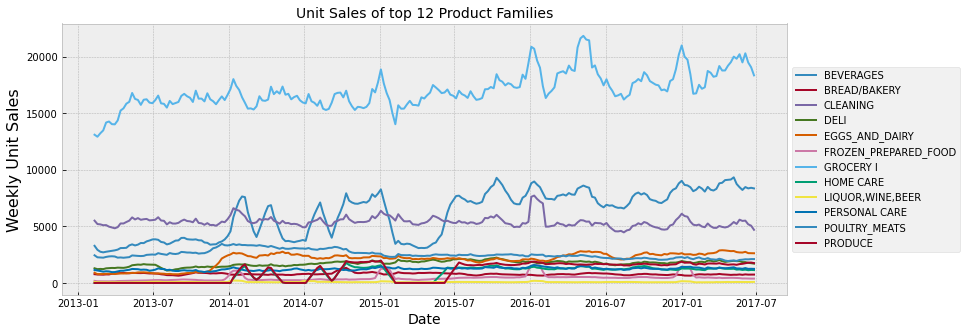

In [16]:
fig, ax = plt.subplots(figsize = (13,5))

for fam in df_ts_smoothed.columns:
    sns.lineplot( ax = ax , data =  df_ts_smoothed, x = df_ts_smoothed.index, y =  df_ts_smoothed[fam], label = fam)
    
plt.ylabel('Weekly Unit Sales', size=16)
plt.xlabel('Date', size=14)
plt.legend()
plt.title('Unit Sales of top 12 Product Families', size=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [17]:
df_ts_smoothed.head(2)

family,BEVERAGES,BREAD/BAKERY,CLEANING,DELI,EGGS_AND_DAIRY,FROZEN_PREPARED_FOOD,GROCERY I,HOME CARE,"LIQUOR,WINE,BEER",PERSONAL CARE,POULTRY_MEATS,PRODUCE
date,,,,,,,,,,,,
2013-02-10,3281.600,774.200,5506.600,1294.800,900.800,184.396,13099.800,0.000,94.600,1144.400,2443.126,0.000
2013-02-17,2927.000,746.000,5204.800,1219.200,776.000,146.518,12922.800,0.000,65.000,1104.000,2265.123,0.000


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

### Family Spotlight: Beverages

In [19]:
# creating new dataframe from beverages column
data_beverages = df_ts_smoothed[['BEVERAGES']]
# inserting new column with yesterday's consumption values
data_beverages.loc[:,'Last_Week'] = data_beverages.loc[:,'BEVERAGES'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_beverages.loc[:,'Last_week_diff'] = data_beverages.loc[:,'Last_Week'].diff()
# dropping NAs
data_beverages = data_beverages.dropna()

/Users/sg/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/sg/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [20]:
data_beverages.head()

family,BEVERAGES,Last_Week,Last_week_diff
date,,,
2013-02-24,2757.600,2927.000,-354.600
2013-03-03,2703.800,2757.600,-169.400
2013-03-10,2756.800,2703.800,-53.800
2013-03-17,2795.000,2756.800,53.000
2013-03-24,2831.600,2795.000,38.200


In [21]:
# defining training & test sets
X_train = data_beverages[:'2016'].drop(['BEVERAGES'], axis = 1)
y_train = data_beverages.loc[:'2016', 'BEVERAGES']
X_test = data_beverages['2017'].drop(['BEVERAGES'], axis = 1)
y_test = data_beverages.loc['2017', 'BEVERAGES']

<ipython-input-21-bfe70a5e5b13>:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = data_beverages['2017'].drop(['BEVERAGES'], axis = 1)


In [22]:
# time series cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [23]:
model_name = 'RandomForest_Store_C'
mlflow.start_run(run_name=model_name)
model = RandomForestRegressor()

param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits = 3) # we split by number of years in our dataset
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid = param_search, scoring = mean_absolute_percentage_error)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

/Users/sg/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: FutureWarning: Pass sample_weight=date
2014-02-16   6256.200
2014-02-23   5398.000
2014-03-02   4567.200
2014-03-09   4060.600
2014-03-16   4732.400
2014-03-23   5436.400
2014-03-30   6185.200
2014-04-06   6789.800
2014-04-13   6875.800
2014-04-20   5882.000
2014-04-27   5275.200
2014-05-04   4557.000
2014-05-11   3941.600
2014-05-18   3690.600
2014-05-25   3716.600
2014-06-01   3657.200
2014-06-08   3601.000
2014-06-15   3672.400
2014-06-22   3724.200
2014-06-29   3793.800
2014-07-06   3722.800
2014-07-13   4700.200
2014-07-20   5394.600
2014-07-27   6051.800
2014-08-03   6597.200
2014-08-10   7113.000
2014-08-17   6184.400
2014-08-24   5451.400
2014-08-31   4628.400
2014-09-07   3998.600
2014-09-14   4841.600
2014-09-21   5712.800
2014-09-28   6297.400
2014-10-05   6960.200
2014-10-12   7925.200
2014-10-19   7277.000
2014-10-26   7110.400
2014-11-02   7011.000
2014-11-09   6996.000
2014-11-16   7077.6

In [24]:
best_model

RandomForestRegressor(max_depth=5, n_estimators=20)

In [25]:
# Predict and find accuracy
y_true = y_test.values
y_pred = best_model.predict(X_test)

mape = mean_absolute_percentage_error(y_true, y_pred)
mlflow.log_metric("MAPE", mape)
mlflow.sklearn.log_model(model, model_name)
mlflow.end_run()

In [26]:
mape

0.03628151407342197

In [27]:
# create prediction dataset
X_test['predictions'] = y_pred.tolist()

In [28]:
X_test['true'] = y_test

In [29]:
# combine train, test & pred for visualizations
X_train['y'] = y_train
beverages = pd.concat([X_train, X_test]).drop(['Last_Week', 'Last_week_diff'], axis = 1)

In [30]:
# create df for plotting
X_train_plt = X_train.drop(['Last_Week', 'Last_week_diff'], axis = 1)
X_test_plt = X_test.drop(['Last_Week', 'Last_week_diff'], axis = 1)

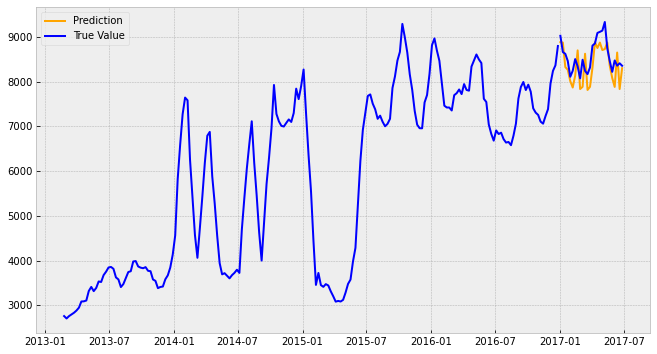

In [31]:
fig, ax = plt.subplots(figsize=(11,6))

plt.plot(X_train_plt, color = 'blue')
plt.plot(X_test_plt['predictions'], label = 'Prediction', color = 'orange')
plt.plot(X_test_plt['true'], label = 'True Value', color = 'blue')
plt.legend()